In [1]:
# Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 490 (delta 149), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (490/490), 136.70 KiB | 19.53 MiB/s, done.
Resolving deltas: 100% (251/251), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
Installing the rest of the RAPIDS 24.4.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.9/920.9 kB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357250 sha256=008e38a2480c726a1b9f3fd3fdeba4d9efd18b04d140c8052ffce3a2676b6ad9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
!gdown 1D9Bge2xywIA4grrkwmW1yHqXnbI8F4hp

Downloading...
From: https://drive.google.com/uc?id=1D9Bge2xywIA4grrkwmW1yHqXnbI8F4hp
To: /content/datacleaned.csv
100% 46.3M/46.3M [00:00<00:00, 49.9MB/s]


In [32]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import IncrementalPCA
from scipy.sparse import csr_matrix
try:
    data = pd.read_csv('datacleaned.csv')
except Exception as e:
    raise FileNotFoundError("Error loading data: " + str(e))


In [33]:
import numpy as np

def escaldor_log(frequency):
    if frequency == 0:
        return 0
    elif frequency == 1:
        return 1
    else:
        return min(5, 1 + 4 * (np.log(frequency) / np.log(max_frequency)))


In [34]:
#mas limpieza
data = data[data["StockCode"] != "POST"]

data['CustomerID'] = data['CustomerID'].astype(int)
data = data.dropna(subset=['CustomerID', 'StockCode', 'Description', 'Quantity', 'InvoiceDate'])
data['CustomerID'] = data['CustomerID'].astype(str)
data['StockCode'] = data['StockCode'].astype(str)

data['Frequency'] = data.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].transform('nunique')
max_frequency = data['Frequency'].max()

data['ScaledFrequency'] = data['Frequency'].apply(escaldor_log)

# Filtrar usuarios que han comprado más de 5 productos diferentes
user_purchase_counts = data.groupby('CustomerID')['StockCode'].nunique()
filtered_users = user_purchase_counts[user_purchase_counts > 10].index
filtered_data = data[data['CustomerID'].isin(filtered_users)]

#matriz
reader = Reader(rating_scale=(0, 5))
surprise_data = Dataset.load_from_df(filtered_data[['CustomerID', 'StockCode', 'ScaledFrequency']], reader)

trainset, testset = train_test_split(surprise_data, test_size=0.25)



<ipython-input-34-9cddb8a2e742>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CustomerID'] = data['CustomerID'].astype(int)


In [35]:
filtered_data.ScaledFrequency.describe()

count    392005.000000
mean          1.533290
std           0.692488
min           1.000000
25%           1.000000
50%           1.000000
75%           1.991792
max           5.000000
Name: ScaledFrequency, dtype: float64

In [36]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Weekday,TotalSales,DiaSemana,Frequency,ScaledFrequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,2,15.30,Wednesday,17,3.557735
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,2,20.34,Wednesday,17,3.557735
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,2,22.00,Wednesday,15,3.444741
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,2,20.34,Wednesday,17,3.557735
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,2,20.34,Wednesday,17,3.557735


In [37]:
model = SVD()
model.fit(trainset)

predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")



RMSE: 0.3329
RMSE: 0.33290452013784777


In [38]:
cross_validate(model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3280  0.3288  0.3285  0.3302  0.3296  0.3290  0.0008  
MAE (testset)     0.2584  0.2594  0.2592  0.2604  0.2602  0.2595  0.0007  
Fit time          4.37    4.42    4.61    4.46    4.54    4.48    0.08    
Test time         0.43    0.79    0.40    0.79    0.40    0.56    0.19    


{'test_rmse': array([0.3279564 , 0.32881496, 0.32848767, 0.33023838, 0.32956601]),
 'test_mae': array([0.25840252, 0.25942813, 0.25922229, 0.26040536, 0.26017267]),
 'fit_time': (4.370035648345947,
  4.420394659042358,
  4.605603456497192,
  4.4593346118927,
  4.536518812179565),
 'test_time': (0.4341888427734375,
  0.7877411842346191,
  0.39968299865722656,
  0.7890405654907227,
  0.3974125385284424)}

In [39]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year



In [66]:
from cuml.cluster import KMeans as cumlKMeans
import cudf
from sklearn.preprocessing import StandardScaler
gdf_data = cudf.DataFrame.from_pandas(filtered_data)

# Agrupamiento de usuarios basado en sus compras
user_item_matrix = filtered_data.pivot_table(index='CustomerID', columns='StockCode', values='ScaledFrequency', fill_value=0)
scaler = StandardScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)

gdf_user_item_matrix = cudf.DataFrame.from_pandas(pd.DataFrame(user_item_matrix_scaled, index=user_item_matrix.index))

user_clusters = cumlKMeans(n_clusters=300, random_state=42)
user_cluster_labels = user_clusters.fit_predict(gdf_user_item_matrix).to_numpy()

user_cluster_map = pd.Series(user_cluster_labels, index=user_item_matrix.index).to_dict()
filtered_data['UserCluster'] = filtered_data['CustomerID'].map(user_cluster_map)

<ipython-input-66-e9736f513950>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['UserCluster'] = filtered_data['CustomerID'].map(user_cluster_map)


In [67]:

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(user_item_matrix_scaled, user_cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.14856417064128313


In [68]:
a=filtered_data.groupby("UserCluster").CustomerID.count().sort_values(ascending=False)
a

UserCluster
266    104596
260     32230
171     25765
99      22441
254     21052
        ...  
272        48
98         45
224        42
81         29
246        23
Name: CustomerID, Length: 300, dtype: int64

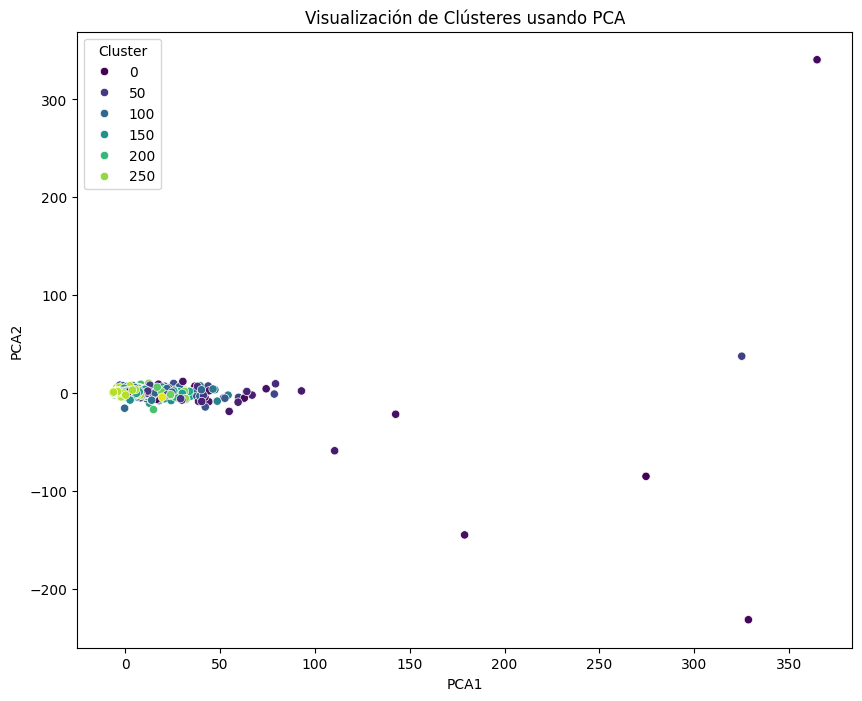

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_item_matrix_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = user_cluster_labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Visualización de Clústeres usando PCA')
plt.show()


In [70]:
# Agrupamiento de productos basado en las ventas
item_user_matrix = filtered_data.pivot_table(index='StockCode', columns='CustomerID', values='ScaledFrequency', fill_value=0)
item_user_matrix_scaled = scaler.fit_transform(item_user_matrix)

gdf_item_user_matrix = cudf.DataFrame.from_pandas(pd.DataFrame(item_user_matrix_scaled, index=item_user_matrix.index))

item_clusters = cumlKMeans(n_clusters=100, random_state=42)
item_cluster_labels = item_clusters.fit_predict(gdf_item_user_matrix).to_numpy()

item_cluster_map = pd.Series(item_cluster_labels, index=item_user_matrix.index).to_dict()
filtered_data['ItemCluster'] = filtered_data['StockCode'].map(item_cluster_map)

<ipython-input-70-a6cafb4b0f75>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ItemCluster'] = filtered_data['StockCode'].map(item_cluster_map)


In [71]:
silhouette_avg = silhouette_score(item_user_matrix_scaled, item_cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2868614097559256


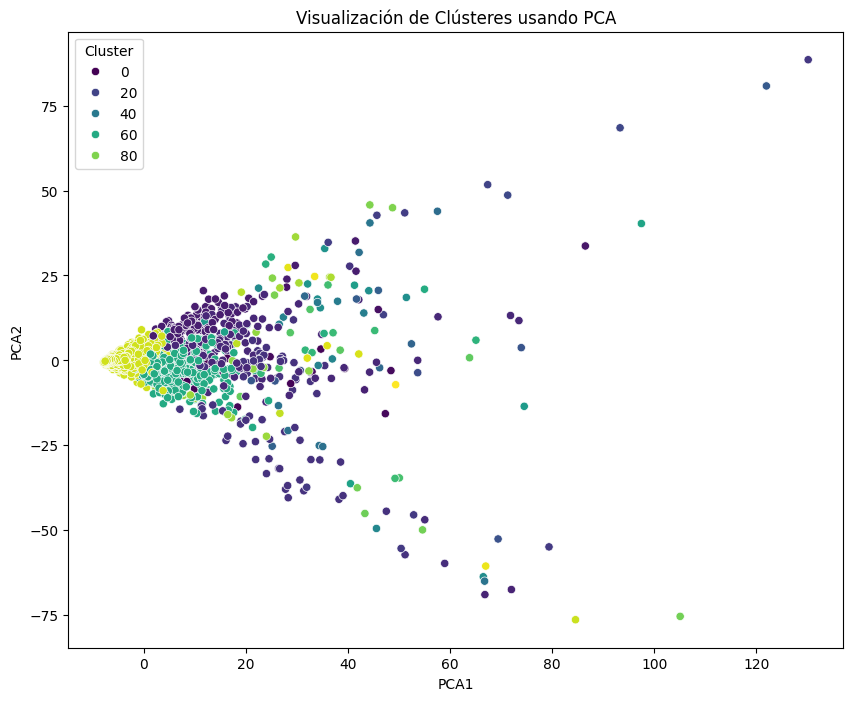

In [72]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_user_matrix_scaled)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = item_cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Visualización de Clústeres usando PCA')
plt.show()


In [73]:
print(filtered_data[['CustomerID', 'UserCluster']].drop_duplicates().isna().sum())
print(filtered_data[['StockCode', 'ItemCluster']].drop_duplicates().isna().sum())

CustomerID     0
UserCluster    0
dtype: int64
StockCode      0
ItemCluster    0
dtype: int64


In [74]:
# productos más vendidos
top_selling_products = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10).index.tolist()

In [75]:
# productos más comprados recientemente
recent_sales = data[data['InvoiceDate'] > (data['InvoiceDate'].max() - pd.DateOffset(months=1))]
recent_top_selling_products = recent_sales.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10).index.tolist()


In [76]:
from collections import Counter
def get_similar_users(user_id):
    if user_id not in filtered_data['CustomerID'].values:
        raise ValueError(f"User ID {user_id} not found in data")
    user_cluster = filtered_data.loc[filtered_data['CustomerID'] == user_id, 'UserCluster'].values[0]
    similar_users = filtered_data[filtered_data['UserCluster'] == user_cluster]['CustomerID'].unique()
    return similar_users

def get_similar_items(item_id):
    if item_id not in filtered_data['StockCode'].values:
        raise ValueError(f"Item ID {item_id} not found in data")
    item_cluster = filtered_data.loc[filtered_data['StockCode'] == item_id, 'ItemCluster'].values[0]
    similar_items = filtered_data[filtered_data['ItemCluster'] == item_cluster]['StockCode'].unique()
    return similar_items
def recommend_with_svd(user_id, n=10):
    user_ratings = []
    user_items = filtered_data[filtered_data['CustomerID'] == user_id]['StockCode'].unique()
    all_items = filtered_data['StockCode'].unique()

    for item in all_items:
        if item not in user_items:
            prediction = model.predict(user_id, item).est
            user_ratings.append((item, prediction))

    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_items = [item for item, rating in user_ratings[:n]]
    return top_items
def recommend_by_customer_cluster(user_id, n=10):
    similar_users = get_similar_users(user_id)
    if len(similar_users) == 0:
        raise ValueError(f"No similar users found for User ID {user_id}")

    similar_user_data = filtered_data[filtered_data['CustomerID'].isin(similar_users)]
    top_products_by_similar_users = similar_user_data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(n).index.tolist()
    return top_products_by_similar_users

def recommend_by_item_cluster(user_id, n=10):
    user_purchased_items = filtered_data[filtered_data['CustomerID'] == user_id]['StockCode'].unique()

    similar_items = []
    for item in user_purchased_items:
        similar_items.extend(get_similar_items(item))
    similar_items = list(set(similar_items))
    top_similar_items = filtered_data[filtered_data['StockCode'].isin(similar_items)].groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(n).index.tolist()
    return top_similar_items
def get_hybrid_recommendations(user_id, n=10):

    if user_id not in filtered_data['CustomerID'].unique():
        raise ValueError(f"User ID {user_id} not found in data")
    user_purchased_items = filtered_data[filtered_data['CustomerID'] == user_id]['StockCode'].unique()

    user_group_recommendations = recommend_by_customer_cluster(user_id, n)
    item_group_recommendations=recommend_by_item_cluster(user_id, n)
    svd_recommendations = recommend_with_svd(user_id, n)

    all_recommendations = list(user_group_recommendations + item_group_recommendations + svd_recommendations)
    all_recommendations=[item for item in all_recommendations if item not in user_purchased_items]
    recommendation_counts = Counter(all_recommendations)

    sorted_recommendations = [item for item, count in recommendation_counts.most_common(n)]
    return sorted_recommendations



In [77]:
user_id = "17850"

In [78]:
# Recomendaciones híbridas
try:
    prod_recomendados = get_hybrid_recommendations(user_id, n=5)
    print("Recomendaciones Hibridas:", prod_recomendados)
except ValueError as e:
    print(e)


Recomendaciones Hibridas: ['22616', '22197', '84077', '85099B', '84879']


In [79]:
# Recomendaciones generales
print("Productos más vendidos:", top_selling_products)
print("Productos más vendidos recientemente:", recent_top_selling_products)

Productos más vendidos: ['23843', '23166', '84077', '22197', '85099B', '85123A', '84879', '21212', '23084', '22492']
Productos más vendidos recientemente: ['23843', '23084', '22197', '84879', '22086', '85099B', '22578', '84077', '20668', '22577']


In [80]:
# Recomendaciones basadas en clústeres de usuarios
try:
    prod_recomendados = recommend_by_customer_cluster(user_id, n=5)
    print("Recomendaciones basadas en clústeres de usuarios:", prod_recomendados)
except ValueError as e:
    print(e)

Recomendaciones basadas en clústeres de usuarios: ['84077', '85099B', '22616', '84879', '22197']


In [81]:
# Recomendaciones basadas en clústeres de ítems
try:
    prod_recomendados = recommend_by_item_cluster(user_id, n=5)
    print("Recomendaciones basadas en clústeres de ítems:", prod_recomendados)
except ValueError as e:
    print(e)

Recomendaciones basadas en clústeres de ítems: ['85123A', '22492', '22616', '21977', '17003']


In [82]:
# Recomendaciones basadas en svd
try:
    prod_recomendados = recommend_with_svd(user_id, n=5)
    print("Recomendaciones basadas en svd:", prod_recomendados)
except ValueError as e:
    print(e)

Recomendaciones basadas en svd: ['21137', '82582', '22383', '22197', '22849']
